# Data Preprocessing & Feature Engineering

**Ziel:** Datenaufbereitung und Feature-Erstellung für Zeitreihenvorhersage

**Inhalte:**
1. Daten laden
2. Fehlende Werte behandeln
3. Ausreißer behandeln
4. Feature Engineering
5. Train/Val/Test Split
6. Skalierung
7. Daten speichern

In [29]:
# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from data.smard_loader import load_smard_data
from data.preprocessing import TimeSeriesPreprocessor, train_test_split_temporal
from visualization.plots import plot_time_series

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 11

print("✅ Libraries loaded")

✅ Libraries loaded


## 1. Daten laden

Lade die Rohdaten von SMARD API

In [30]:
# Konfiguration
DATA_TYPE = 'solar'  # Ändere hier für andere Datenquellen
START_DATE = '2022-01-01'
END_DATE = '2024-12-31'
RESOLUTION = 'hour'

print(f"Lade {DATA_TYPE}-Daten von {START_DATE} bis {END_DATE}...\n")

Lade solar-Daten von 2022-01-01 bis 2024-12-31...



In [31]:
# Daten laden
df = load_smard_data(
    filter_name=DATA_TYPE,
    start_date=START_DATE,
    end_date=END_DATE,
    resolution=RESOLUTION,
    cache_dir=Path('../data/raw')
)

print(f"✅ {len(df)} Datenpunkte geladen")
print(f"Zeitraum: {df['timestamp'].min()} bis {df['timestamp'].max()}")
display(df.head())

Loading from cache: ../data/raw/solar_2022-01-01_2024-12-31_hour.csv
✅ 26257 Datenpunkte geladen
Zeitraum: 2022-01-02 23:00:00 bis 2024-12-31 23:00:00


,timestamp,value
0,2022-01-02 23:00:00,2.0
1,2022-01-03 00:00:00,2.0
2,2022-01-03 01:00:00,2.0
3,2022-01-03 02:00:00,2.0
4,2022-01-03 03:00:00,2.0


## 2. Fehlende Werte behandeln

In [32]:
# Fehlende Werte analysieren
missing = df['value'].isna().sum()
missing_pct = missing / len(df) * 100

print(f"Fehlende Werte: {missing} ({missing_pct:.2f}%)")

if missing > 0:
    # Visualisierung der fehlenden Werte
    fig, ax = plt.subplots(figsize=(16, 2))
    missing_mask = df['value'].isna()
    ax.scatter(df[missing_mask]['timestamp'], [1]*missing_mask.sum(), 
               color='red', marker='|', s=100, alpha=0.5)
    ax.set_title('Fehlende Werte (rot)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Zeit')
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()

Fehlende Werte: 0 (0.00%)


In [5]:
# Fehlende Werte behandeln
prep = TimeSeriesPreprocessor()

df_clean = prep.handle_missing_values(
    df,
    value_col='value',
    method='interpolate'  # Optionen: 'interpolate', 'ffill', 'bfill', 'mean', 'drop'
)

# Verifikation
missing_after = df_clean['value'].isna().sum()
print(f"\nFehlende Werte nach Behandlung: {missing_after}")

if missing > 0 and missing_after == 0:
    print("✅ Alle fehlenden Werte wurden erfolgreich behandelt")


Fehlende Werte nach Behandlung: 0


## 3. Ausreißer behandeln

Ausreißer (IQR-Methode): 2093 (7.97%)
Wertebereich: 1 - 46898
IQR-Grenzen: -15822 - 26380


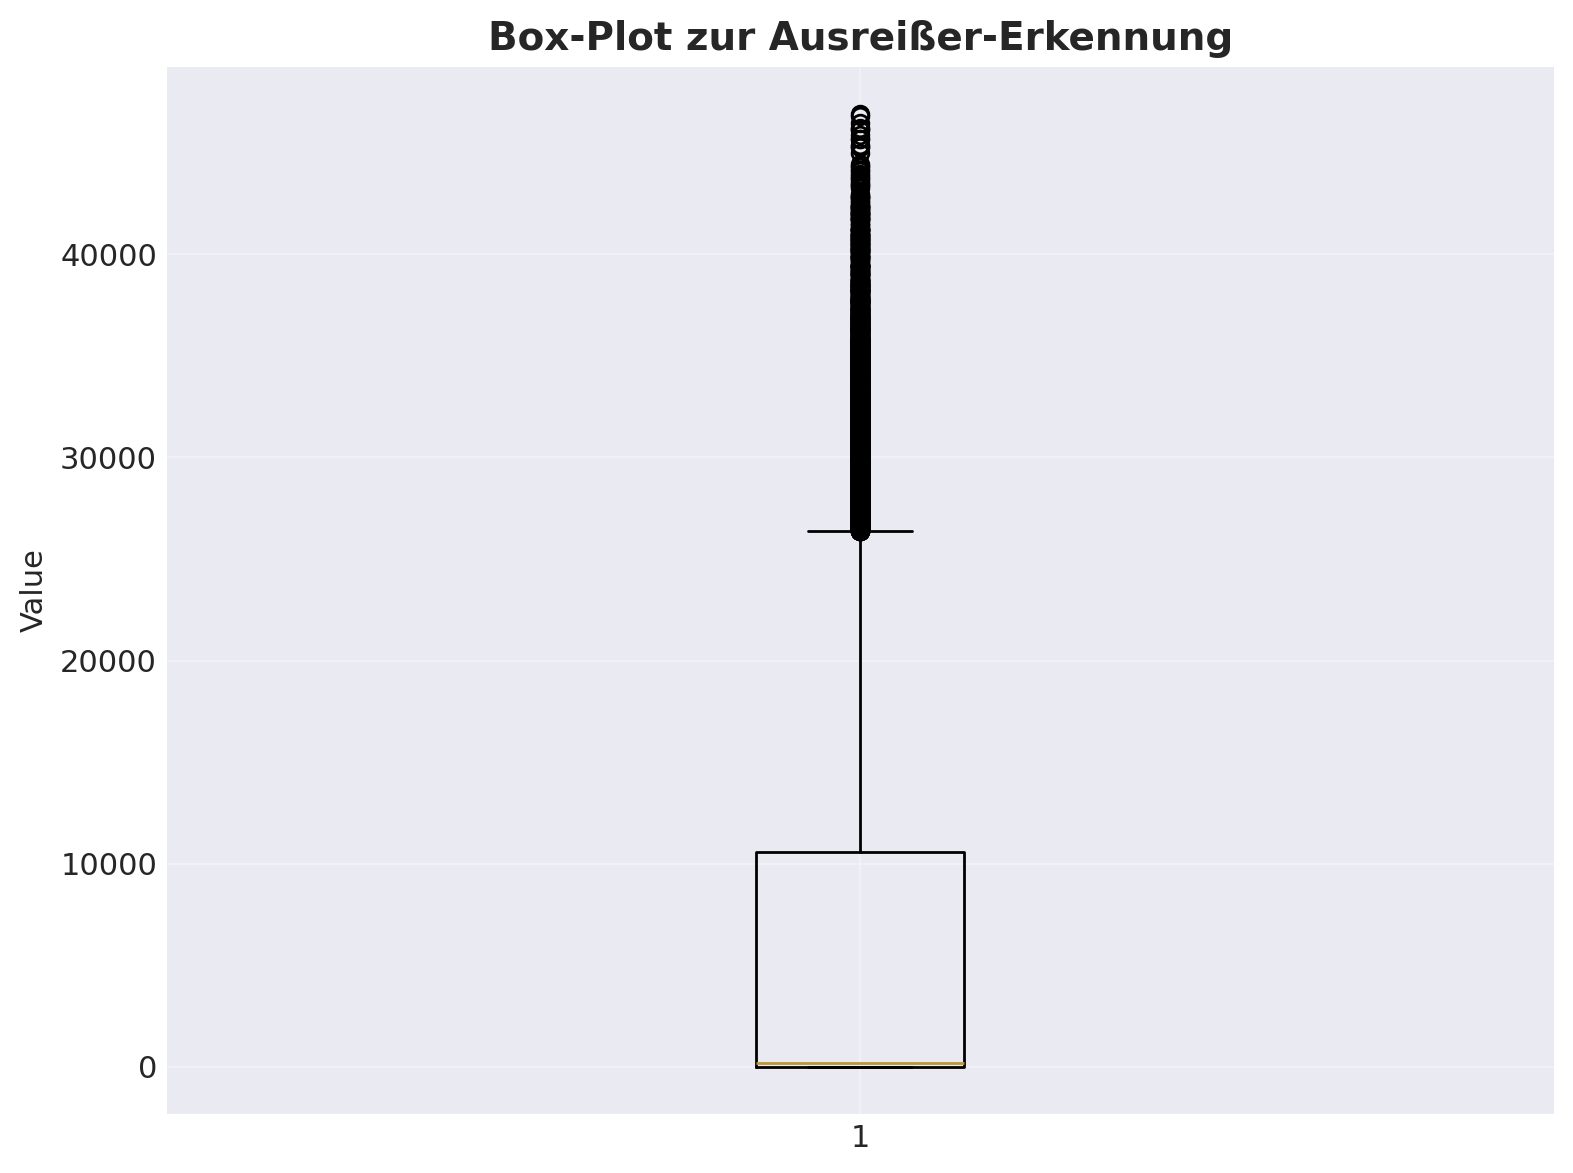

In [6]:
# Ausreißer erkennen (IQR-Methode)
Q1 = df_clean['value'].quantile(0.25)
Q3 = df_clean['value'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = ((df_clean['value'] < lower) | (df_clean['value'] > upper)).sum()
outliers_pct = outliers / len(df_clean) * 100

print(f"Ausreißer (IQR-Methode): {outliers} ({outliers_pct:.2f}%)")
print(f"Wertebereich: {df_clean['value'].min():.0f} - {df_clean['value'].max():.0f}")
print(f"IQR-Grenzen: {lower:.0f} - {upper:.0f}")

# Box-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(df_clean['value'].dropna(), vert=True)
ax.set_ylabel('Value')
ax.set_title('Box-Plot zur Ausreißer-Erkennung', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
# Entscheidung: Ausreißer behandeln oder nicht?
HANDLE_OUTLIERS = False  # Setze auf True wenn gewünscht

if HANDLE_OUTLIERS:
    df_clean = prep.handle_outliers(
        df_clean,
        value_col='value',
        method='iqr',  # 'iqr', 'zscore', 'clip'
        threshold=1.5
    )
    print("✅ Ausreißer wurden behandelt")
else:
    print("ℹ️ Ausreißer werden nicht behandelt (oft bei Energie-Daten sinnvoll)")

ℹ️ Ausreißer werden nicht behandelt (oft bei Energie-Daten sinnvoll)


## 4. Feature Engineering

### 4.1 Zeit-Features

In [34]:
# Zeit-Features erstellen
df_features = prep.create_time_features(df_clean, timestamp_col='timestamp')

print("Neu erstellte Zeit-Features:")
time_features = ['year', 'month', 'day', 'dayofweek', 'hour', 
                 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 
                 'is_weekend', 'is_month_start']
display(df_features[['timestamp'] + time_features].head(10))

Neu erstellte Zeit-Features:


,timestamp,year,month,day,dayofweek,hour,month_sin,month_cos,hour_sin,hour_cos,is_weekend,is_month_start
0,2022-01-02 23:00:00,2022,1,2,6,23,0.5,0.866025,-0.258819,9.659258e-01,1,0
1,2022-01-03 00:00:00,2022,1,3,0,0,0.5,0.866025,0.000000,1.000000e+00,0,0
2,2022-01-03 01:00:00,2022,1,3,0,1,0.5,0.866025,0.258819,9.659258e-01,0,0
3,2022-01-03 02:00:00,2022,1,3,0,2,0.5,0.866025,0.500000,8.660254e-01,0,0
4,2022-01-03 03:00:00,2022,1,3,0,3,0.5,0.866025,0.707107,7.071068e-01,0,0
5,2022-01-03 04:00:00,2022,1,3,0,4,0.5,0.866025,0.866025,5.000000e-01,0,0
6,2022-01-03 05:00:00,2022,1,3,0,5,0.5,0.866025,0.965926,2.588190e-01,0,0
7,2022-01-03 06:00:00,2022,1,3,0,6,0.5,0.866025,1.000000,6.123234e-17,0,0
8,2022-01-03 07:00:00,2022,1,3,0,7,0.5,0.866025,0.965926,-2.588190e-01,0,0
9,2022-01-03 08:00:00,2022,1,3,0,8,0.5,0.866025,0.866025,-5.000000e-01,0,0


### 4.2 Lag-Features

In [35]:
# Lag-Features erstellen
# Für stündliche Daten sinnvoll: 1h, 24h (1 Tag), 168h (1 Woche)
LAGS = [1, 2, 3, 24, 48, 168]

df_features = prep.create_lag_features(
    df_features,
    value_col='value',
    lags=LAGS
)

print(f"Erstellte Lag-Features: {LAGS}")
lag_cols = [f'lag_{lag}' for lag in LAGS]
display(df_features[['timestamp', 'value'] + lag_cols].head(200))

Erstellte Lag-Features: [1, 2, 3, 24, 48, 168]


,timestamp,value,lag_1,lag_2,lag_3,lag_24,lag_48,lag_168
0,2022-01-02 23:00:00,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-03 00:00:00,2.0,2.0,NaN,NaN,NaN,NaN,NaN
2,2022-01-03 01:00:00,2.0,2.0,2.0,NaN,NaN,NaN,NaN
3,2022-01-03 02:00:00,2.0,2.0,2.0,2.0,NaN,NaN,NaN
4,2022-01-03 03:00:00,2.0,2.0,2.0,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
195,2022-01-11 02:00:00,3.0,2.5,2.0,2.0,2.75,2.25,2.0
196,2022-01-11 03:00:00,2.5,3.0,2.5,2.0,2.00,2.00,2.0
197,2022-01-11 04:00:00,2.0,2.5,3.0,2.5,2.25,2.00,2.0
198,2022-01-11 05:00:00,2.0,2.0,2.5,3.0,2.75,2.00,2.0


### 4.3 Rolling-Window Features

In [36]:
# Rolling-Features erstellen
WINDOWS = [24, 168]  # 24h (1 Tag), 168h (1 Woche)
FUNCTIONS = ['mean', 'std', 'min', 'max']

df_features = prep.create_rolling_features(
    df_features,
    value_col='value',
    windows=WINDOWS,
    functions=FUNCTIONS
)

print(f"Erstellte Rolling-Features: Windows={WINDOWS}, Functions={FUNCTIONS}")
rolling_cols = [f'rolling_{w}_{f}' for w in WINDOWS for f in FUNCTIONS]
display(df_features[['timestamp', 'value'] + rolling_cols[:4]].head())

Erstellte Rolling-Features: Windows=[24, 168], Functions=['mean', 'std', 'min', 'max']


,timestamp,value,rolling_24_mean,rolling_24_std,rolling_24_min,rolling_24_max
0,2022-01-02 23:00:00,2.0,2.0,NaN,2.0,2.0
1,2022-01-03 00:00:00,2.0,2.0,0.0,2.0,2.0
2,2022-01-03 01:00:00,2.0,2.0,0.0,2.0,2.0
3,2022-01-03 02:00:00,2.0,2.0,0.0,2.0,2.0
4,2022-01-03 03:00:00,2.0,2.0,0.0,2.0,2.0


### 4.4 Feature-Übersicht

In [27]:
print("=" * 60)
print("FEATURE-ÜBERSICHT")
print("=" * 60)
print(f"\nAnzahl Features: {len(df_features.columns)}")
print(f"Anzahl Zeilen: {len(df_features)}")
print(f"\nSpalten:")
for col in df_features.columns:
    print(f"  - {col}")

# Fehlende Werte durch Features
print(f"\nFehlende Werte pro Feature:")
missing_per_col = df_features.isna().sum()
missing_per_col = missing_per_col[missing_per_col > 0].sort_values(ascending=False)
if len(missing_per_col) > 0:
    print(missing_per_col)
else:
    print("  Keine fehlenden Werte!")

FEATURE-ÜBERSICHT

Anzahl Features: 33
Anzahl Zeilen: 26257

Spalten:
  - timestamp
  - value
  - year
  - month
  - day
  - dayofweek
  - dayofyear
  - weekofyear
  - quarter
  - hour
  - month_sin
  - month_cos
  - dayofweek_sin
  - dayofweek_cos
  - hour_sin
  - hour_cos
  - is_weekend
  - is_month_start
  - is_month_end
  - lag_1
  - lag_2
  - lag_3
  - lag_24
  - lag_48
  - lag_168
  - rolling_24_mean
  - rolling_24_std
  - rolling_24_min
  - rolling_24_max
  - rolling_168_mean
  - rolling_168_std
  - rolling_168_min
  - rolling_168_max

Fehlende Werte pro Feature:
lag_168            168
lag_48              48
lag_24              24
lag_3                3
lag_2                2
lag_1                1
rolling_24_std       1
rolling_168_std      1
dtype: int64


## 5. Train/Validation/Test Split

**Wichtig:** Bei Zeitreihen IMMER chronologisch splitten!

In [12]:
# Entferne Zeilen mit NaN (durch Lag-Features entstanden)
df_complete = df_features.dropna().reset_index(drop=True)

print(f"Datenpunkte nach Entfernen von NaN: {len(df_complete)} (war: {len(df_features)})")
print(f"Zeitraum: {df_complete['timestamp'].min()} bis {df_complete['timestamp'].max()}")

Datenpunkte nach Entfernen von NaN: 26089 (war: 26257)
Zeitraum: 2022-01-09 23:00:00 bis 2024-12-31 23:00:00


In [13]:
# Chronologischer Split: 70% Train, 15% Validation, 15% Test
train_df, val_df, test_df = train_test_split_temporal(
    df_complete,
    test_size=0.15,
    val_size=0.15
)

print("=" * 60)
print("TRAIN/VAL/TEST SPLIT")
print("=" * 60)
print(f"\nTrain: {len(train_df)} Zeilen ({len(train_df)/len(df_complete)*100:.1f}%)")
print(f"  Von: {train_df['timestamp'].min()}")
print(f"  Bis: {train_df['timestamp'].max()}")

print(f"\nValidation: {len(val_df)} Zeilen ({len(val_df)/len(df_complete)*100:.1f}%)")
print(f"  Von: {val_df['timestamp'].min()}")
print(f"  Bis: {val_df['timestamp'].max()}")

print(f"\nTest: {len(test_df)} Zeilen ({len(test_df)/len(df_complete)*100:.1f}%)")
print(f"  Von: {test_df['timestamp'].min()}")
print(f"  Bis: {test_df['timestamp'].max()}")
print("\n" + "=" * 60)

TRAIN/VAL/TEST SPLIT

Train: 18262 Zeilen (70.0%)
  Von: 2022-01-09 23:00:00
  Bis: 2024-02-09 20:00:00

Validation: 3913 Zeilen (15.0%)
  Von: 2024-02-09 21:00:00
  Bis: 2024-07-21 21:00:00

Test: 3914 Zeilen (15.0%)
  Von: 2024-07-21 22:00:00
  Bis: 2024-12-31 23:00:00



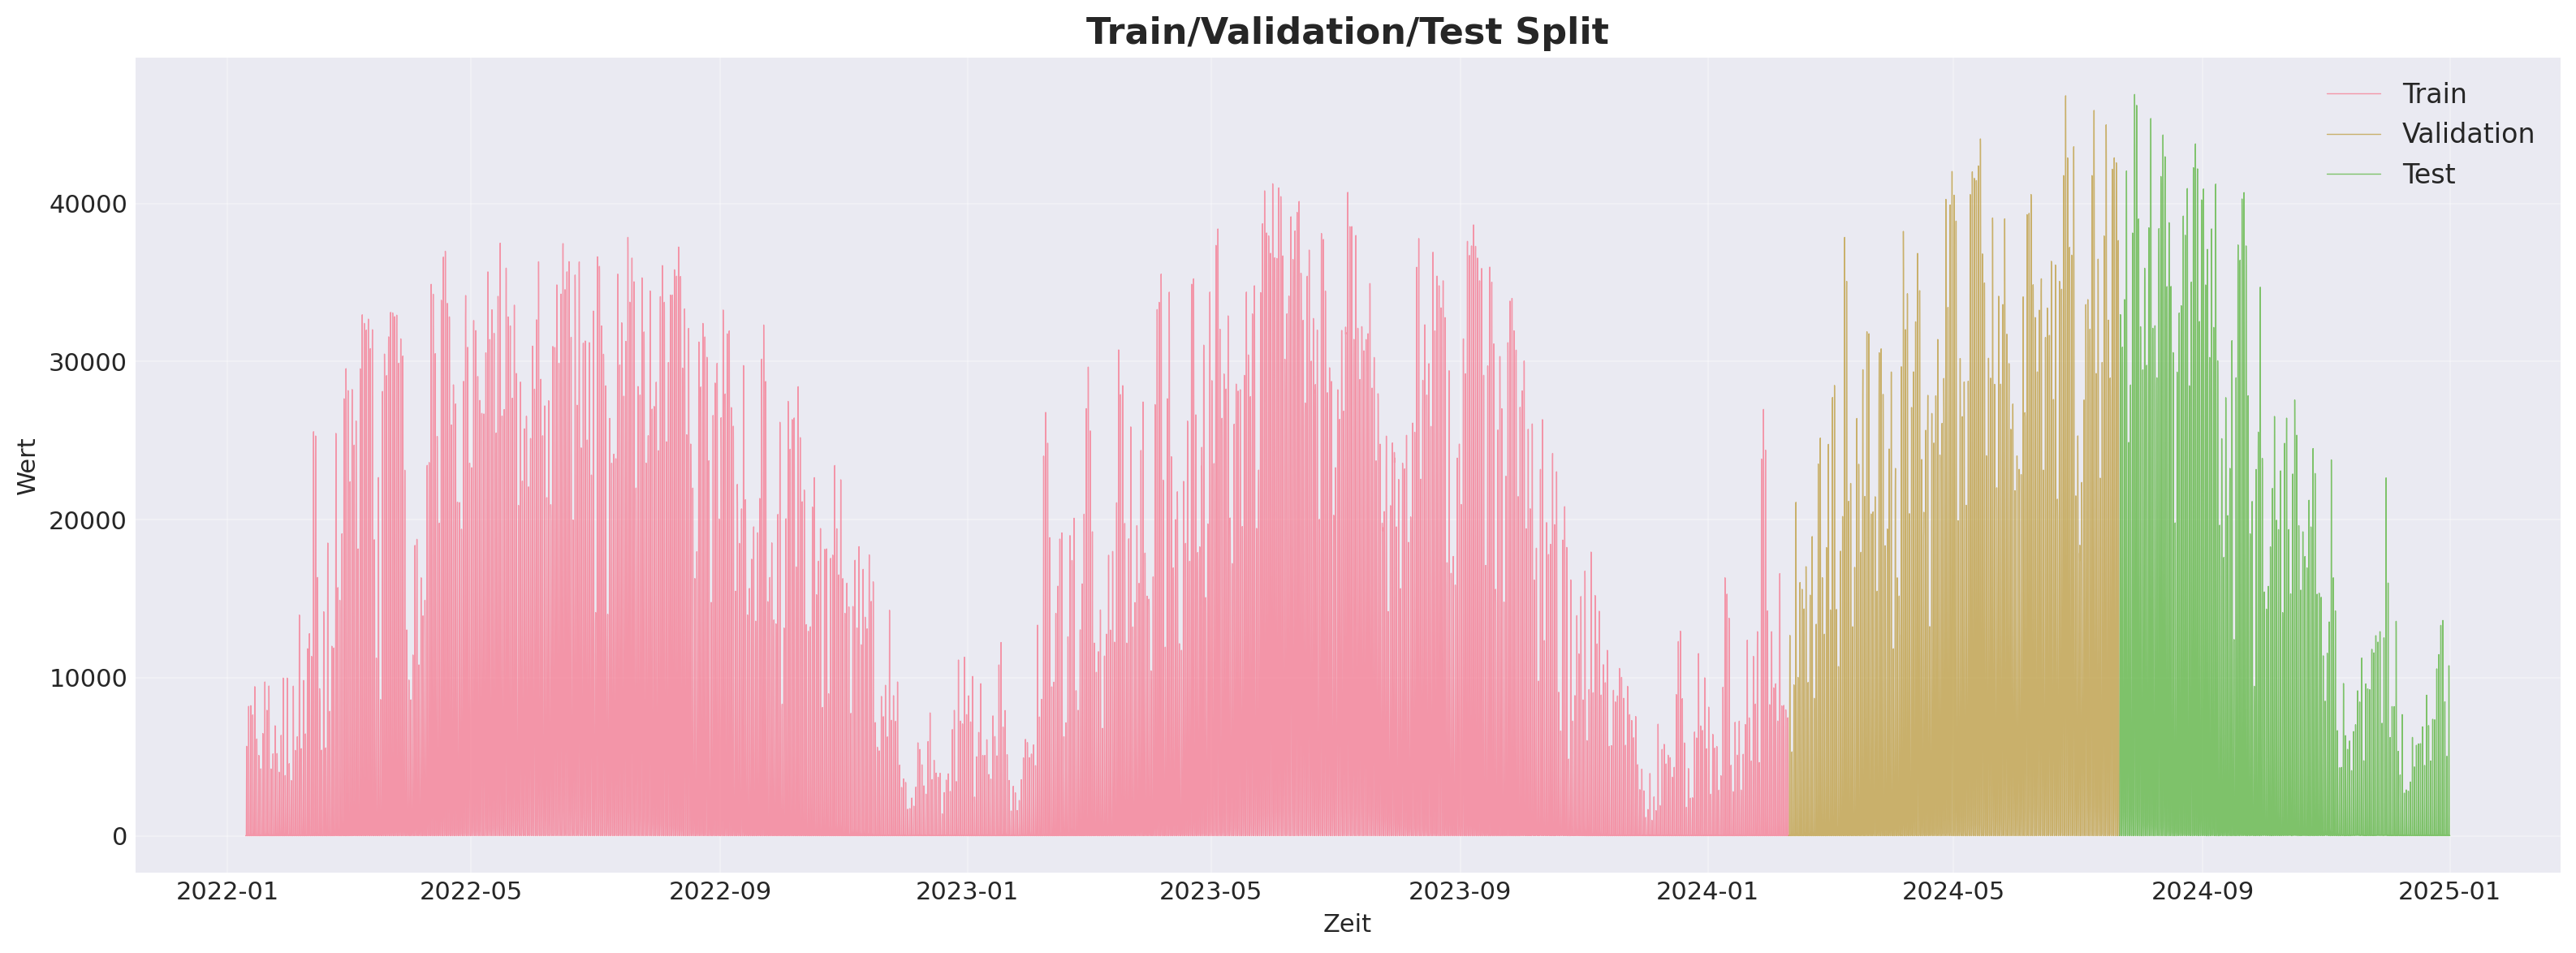

In [37]:
# Visualisierung des Splits
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(train_df['timestamp'], train_df['value'], label='Train', alpha=0.7, linewidth=0.5)
ax.plot(val_df['timestamp'], val_df['value'], label='Validation', alpha=0.7, linewidth=0.5)
ax.plot(test_df['timestamp'], test_df['value'], label='Test', alpha=0.7, linewidth=0.5)

ax.set_title('Train/Validation/Test Split', fontsize=16, fontweight='bold')
ax.set_xlabel('Zeit')
ax.set_ylabel('Wert')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Feature-Skalierung (Optional)

Wichtig für Deep Learning Modelle. Für Tree-based Modelle oft nicht nötig.

In [28]:
# Feature-Spalten identifizieren (alle außer timestamp und value)
feature_cols = [col for col in df_complete.columns if col not in ['timestamp', 'value']]

print(f"Features die skaliert werden: {len(feature_cols)}")
print(feature_cols[:10], "...")

Features die skaliert werden: 31
['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'hour', 'month_sin', 'month_cos'] ...


In [16]:
# Skalierung (Standard-Skalierung)
# WICHTIG: Nur auf Training-Daten fitten!
scaler_prep = TimeSeriesPreprocessor()

train_scaled, val_scaled = scaler_prep.scale_data(
    train_df,
    val_df,
    feature_cols=feature_cols + ['value'],  # auch value skalieren
    method='standard'  # 'standard' oder 'minmax'
)

_, test_scaled = scaler_prep.scale_data(
    train_df,
    test_df,
    feature_cols=feature_cols + ['value'],
    method='standard'
)

print("✅ Skalierung durchgeführt")
print(f"\nBeispiel (vor Skalierung):")
print(train_df[['value', 'hour', 'lag_1']].head())
print(f"\nBeispiel (nach Skalierung):")
print(train_scaled[['value', 'hour', 'lag_1']].head())

✅ Skalierung durchgeführt

Beispiel (vor Skalierung):
   value  hour  lag_1
0   2.00    23   2.00
1   2.00     0   2.00
2   2.00     1   2.00
3   2.75     2   2.00
4   2.00     3   2.75

Beispiel (nach Skalierung):
      value      hour     lag_1
0 -0.642138  1.661582 -0.642138
1 -0.642138 -1.661266 -0.642138
2 -0.642138 -1.516794 -0.642138
3 -0.642060 -1.372323 -0.642138
4 -0.642138 -1.227851 -0.642060


## 7. Daten speichern

In [17]:
# Verzeichnis erstellen
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# Unskalierte Daten speichern
train_df.to_csv(output_dir / f'{DATA_TYPE}_train.csv', index=False)
val_df.to_csv(output_dir / f'{DATA_TYPE}_val.csv', index=False)
test_df.to_csv(output_dir / f'{DATA_TYPE}_test.csv', index=False)

# Skalierte Daten speichern
train_scaled.to_csv(output_dir / f'{DATA_TYPE}_train_scaled.csv', index=False)
val_scaled.to_csv(output_dir / f'{DATA_TYPE}_val_scaled.csv', index=False)
test_scaled.to_csv(output_dir / f'{DATA_TYPE}_test_scaled.csv', index=False)

print("✅ Daten gespeichert in:", output_dir)
print("\nGespeicherte Dateien:")
for file in output_dir.glob(f'{DATA_TYPE}_*.csv'):
    print(f"  - {file.name}")

✅ Daten gespeichert in: ../data/processed

Gespeicherte Dateien:
  - solar_test.csv
  - solar_train.csv
  - solar_train_scaled.csv
  - solar_val.csv
  - solar_test_scaled.csv
  - solar_2022-01-01_2024-12-31_initial.csv
  - solar_val_scaled.csv


## 8. Zusammenfassung

### Was wurde gemacht:

1. ✅ Rohdaten geladen
2. ✅ Fehlende Werte behandelt (Interpolation)
3. ✅ Ausreißer analysiert (optional behandelt)
4. ✅ Zeit-Features erstellt (Stunde, Tag, Monat, etc.)
5. ✅ Lag-Features erstellt
6. ✅ Rolling-Window Features erstellt
7. ✅ Train/Val/Test Split (chronologisch)
8. ✅ Skalierung durchgeführt
9. ✅ Aufbereitete Daten gespeichert

### Nächste Schritte:

**Baseline-Modelle erstellen** → `03_baseline_models.ipynb`
- Naive Forecast
- Seasonal Naive
- Moving Average

In [18]:
print("=" * 60)
print("PREPROCESSING ABGESCHLOSSEN ✅")
print("=" * 60)
print(f"\nDaten bereit für Modellierung!")
print(f"\nDatensätze:")
print(f"  - Training:   {len(train_df):,} Zeilen")
print(f"  - Validation: {len(val_df):,} Zeilen")
print(f"  - Test:       {len(test_df):,} Zeilen")
print(f"\nFeatures: {len(feature_cols)}")
print(f"\nWeiter zu: notebooks/03_baseline_models.ipynb")

PREPROCESSING ABGESCHLOSSEN ✅

Daten bereit für Modellierung!

Datensätze:
  - Training:   18,262 Zeilen
  - Validation: 3,913 Zeilen
  - Test:       3,914 Zeilen

Features: 31

Weiter zu: notebooks/03_baseline_models.ipynb
